In [24]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg


# additional libraries
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import cv2
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Register data set

In [8]:
def get_data_matrices_dicts():
    df = pd.read_json('export-2020-01-21T22_38_10.814Z.json')
    dataset_dicts = []
    num_img = 0
    for i in range(len(df)):
        num_img+=1
        record = {}
        objs = []
        
        filename = df['External ID'][i]
        width, height = Image.open(os.path.join("dataset_datamatrix/", filename)).size
        
        record["file_name"] = os.path.join("dataset_datamatrix/", filename)
        record["image_id"] = num_img
        record["height"] = height
        record["width"] = width
        
        for n_bbox in range (len(df['Label'][i]['DataMatrix'])):
            coordinates = df['Label'][i]['DataMatrix'][n_bbox]
            points = []
            min_x = width
            min_y = height
            max_x = 0
            max_y = 0
            for ii in range(4):
                    if (coordinates['geometry'][ii]['x']>max_x):
                        max_x = coordinates['geometry'][ii]['x']
                    if (coordinates['geometry'][ii]['x']<min_x):
                        min_x = coordinates['geometry'][ii]['x']
                    if (coordinates['geometry'][ii]['y']>max_y):
                        max_y = coordinates['geometry'][ii]['y']
                    if (coordinates['geometry'][ii]['y']<min_y):
                        min_y = coordinates['geometry'][ii]['y']
                    
                    points.append((coordinates['geometry'][ii]['x']+0.5,coordinates['geometry'][ii]['y']+0.5))
                    
            obj = {
                "bbox": [min_x,min_y,max_x,max_y],
                "bbox_mode": BoxMode.XYXY_ABS,
                "Segmentation": [points],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

In [9]:
dataset = get_data_matrices_dicts()

In [10]:
DatasetCatalog.register("Data_matrix_set", lambda:get_data_matrices_dicts())
MetadataCatalog.get("Data_matrix_set").set(thing_classes=["data_matrix"])
data_matrix_metadata = MetadataCatalog.get("Data_matrix_set")

### Register test set

In [11]:
def get_test_set_dicts():
    df_oficina = pd.read_json('oficina-set.json')
    df_corredor = pd.read_json('corredor-set.json')
    df2_corredor = df_corredor.loc[(df_corredor['Label']!='Skip') & (df_corredor['Label']!={})]
    df2_corredor.set_index("ID",inplace=True)
    df_oficina.set_index("ID",inplace=True)
    frames = [df2_corredor,df_oficina]
    df = pd.concat(frames)
    dataset_dicts = []
    num_img = 0
    for i in range(len(df)):
        num_img+=1
        record = {}
        objs = []
        
        filename = df['External ID'][i]
        width, height = Image.open(os.path.join("final_test_set/", filename)).size
        
        record["file_name"] = os.path.join("final_test_set/", filename)
        record["image_id"] = num_img
        record["height"] = height
        record["width"] = width
        
        for n_bbox in range (len(df['Label'][i]['DataMatrix'])):
            coordinates = df['Label'][i]['DataMatrix'][n_bbox]
            points = []
            min_x = width
            min_y = height
            max_x = 0
            max_y = 0
            for ii in range(4):
                    if (coordinates['geometry'][ii]['x']>max_x):
                        max_x = coordinates['geometry'][ii]['x']
                    if (coordinates['geometry'][ii]['x']<min_x):
                        min_x = coordinates['geometry'][ii]['x']
                    if (coordinates['geometry'][ii]['y']>max_y):
                        max_y = coordinates['geometry'][ii]['y']
                    if (coordinates['geometry'][ii]['y']<min_y):
                        min_y = coordinates['geometry'][ii]['y']
                    
                    points.append((coordinates['geometry'][ii]['x']+0.5,coordinates['geometry'][ii]['y']+0.5))
                    
            obj = {
                "bbox": [min_x,min_y,max_x,max_y],
                "bbox_mode": BoxMode.XYXY_ABS,
                "Segmentation": [points],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

In [12]:
test_set = get_test_set_dicts()

In [13]:
DatasetCatalog.register("Data_matrix_test_set", lambda:get_test_set_dicts())
MetadataCatalog.get("Data_matrix_test_set").set(thing_classes=["data_matrix"])
data_matrix_test_metadata = MetadataCatalog.get("Data_matrix_test_set")

# Define configuration training  

In [19]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("Data_matrix_set",)
cfg.DATASETS.TEST = ("Data_matrix_test_set",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 4000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (data_matrix)

In [20]:
torch.cuda.set_device(1)

In [21]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/30 05:42:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

'roi_heads.box_predictor.cls_score.weight' has shape (81, 2048) in the checkpoint but (2, 2048) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 2048) in the checkpoint but (4, 2048) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.


[01/30 05:42:19 d2.engine.train_loop]: Starting training from iteration 0


/home/tmr/miniconda3/envs/torch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:603: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/home/tmr/miniconda3/envs/torch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:603: UserWarning: Metadata Warning, tag 283 had too many entries: 2, expected 1
  % (tag, len(values))
/home/tmr/miniconda3/envs/torch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:603: UserWarning: Metadata Warning, tag 34853 had too many entries: 9, expected 1
  % (tag, len(values))
/home/tmr/miniconda3/envs/torch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:603: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/home/tmr/miniconda3/envs/torch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:603: UserWarning: Metadata Warning, tag 283 had too many entries: 2, expected 1
  % (tag, len(values))
/home/tmr/miniconda3/envs/torch/lib/python3.7/site-packages/PIL/Tiff

[01/30 05:42:49 d2.utils.events]: eta: 1:34:59  iter: 19  total_loss: 1.230  loss_cls: 0.673  loss_box_reg: 0.375  loss_rpn_cls: 0.164  loss_rpn_loc: 0.013  time: 1.4300  data_time: 1.2775  lr: 0.000005  max_mem: 1943M
[01/30 05:43:17 d2.utils.events]: eta: 1:33:01  iter: 39  total_loss: 1.116  loss_cls: 0.631  loss_box_reg: 0.302  loss_rpn_cls: 0.171  loss_rpn_loc: 0.012  time: 1.4252  data_time: 1.2472  lr: 0.000010  max_mem: 1943M
[01/30 05:43:46 d2.utils.events]: eta: 1:32:24  iter: 59  total_loss: 1.181  loss_cls: 0.555  loss_box_reg: 0.435  loss_rpn_cls: 0.166  loss_rpn_loc: 0.016  time: 1.4164  data_time: 1.2236  lr: 0.000015  max_mem: 1943M
[01/30 05:44:13 d2.utils.events]: eta: 1:30:55  iter: 79  total_loss: 1.081  loss_cls: 0.477  loss_box_reg: 0.482  loss_rpn_cls: 0.155  loss_rpn_loc: 0.016  time: 1.4044  data_time: 1.1928  lr: 0.000020  max_mem: 1943M
[01/30 05:44:40 d2.utils.events]: eta: 1:29:59  iter: 99  total_loss: 0.934  loss_cls: 0.386  loss_box_reg: 0.413  loss_rpn_

{}

In [31]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# Eval model

In [25]:
evaluator = COCOEvaluator("Data_matrix_test_set", cfg, False, output_dir="./output/")

WARNING [01/30 07:15:39 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'Data_matrix_test_set'
[01/30 07:15:39 d2.data.datasets.coco]: Cached annotations in COCO format already exist: ./output/Data_matrix_test_set_coco_format.json


In [26]:
val_loader = build_detection_test_loader(cfg, "Data_matrix_test_set")

In [27]:
inference_on_dataset(trainer.model, val_loader, evaluator)

[01/30 07:15:43 d2.evaluation.evaluator]: Start inference on 224 images
[01/30 07:15:45 d2.evaluation.evaluator]: Inference done 11/224. 0.1419 s / img. ETA=0:00:30
[01/30 07:15:50 d2.evaluation.evaluator]: Inference done 47/224. 0.1376 s / img. ETA=0:00:24
[01/30 07:15:55 d2.evaluation.evaluator]: Inference done 84/224. 0.1365 s / img. ETA=0:00:19
[01/30 07:16:00 d2.evaluation.evaluator]: Inference done 120/224. 0.1366 s / img. ETA=0:00:14
[01/30 07:16:05 d2.evaluation.evaluator]: Inference done 155/224. 0.1376 s / img. ETA=0:00:09
[01/30 07:16:10 d2.evaluation.evaluator]: Inference done 183/224. 0.1403 s / img. ETA=0:00:06
[01/30 07:16:15 d2.evaluation.evaluator]: Inference done 209/224. 0.1425 s / img. ETA=0:00:02
[01/30 07:16:18 d2.evaluation.evaluator]: Total inference time: 0:00:33.969747 (0.155113 s / img per device, on 1 devices)
[01/30 07:16:18 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:31 (0.143537 s / img per device, on 1 devices)
[01/30 07:16:18 d2.ev

OrderedDict([('bbox',
              {'AP': 61.90755133992468,
               'AP50': 87.64578646622822,
               'AP75': 72.95348779689844,
               'APs': 36.427861148708296,
               'APm': 56.49392294613014,
               'APl': 73.65728622322648})])

# Check one prediction

In [32]:
predictor = DefaultPredictor(cfg)

In [36]:
im = cv2.imread('final_test_set/IMG_3130.JPG')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [37]:
outputs = predictor(im)
outputs["instances"].pred_classes
outputs["instances"].pred_boxes
outputs["instances"].pred_boxes[outputs["instances"].scores.argmax().item()];

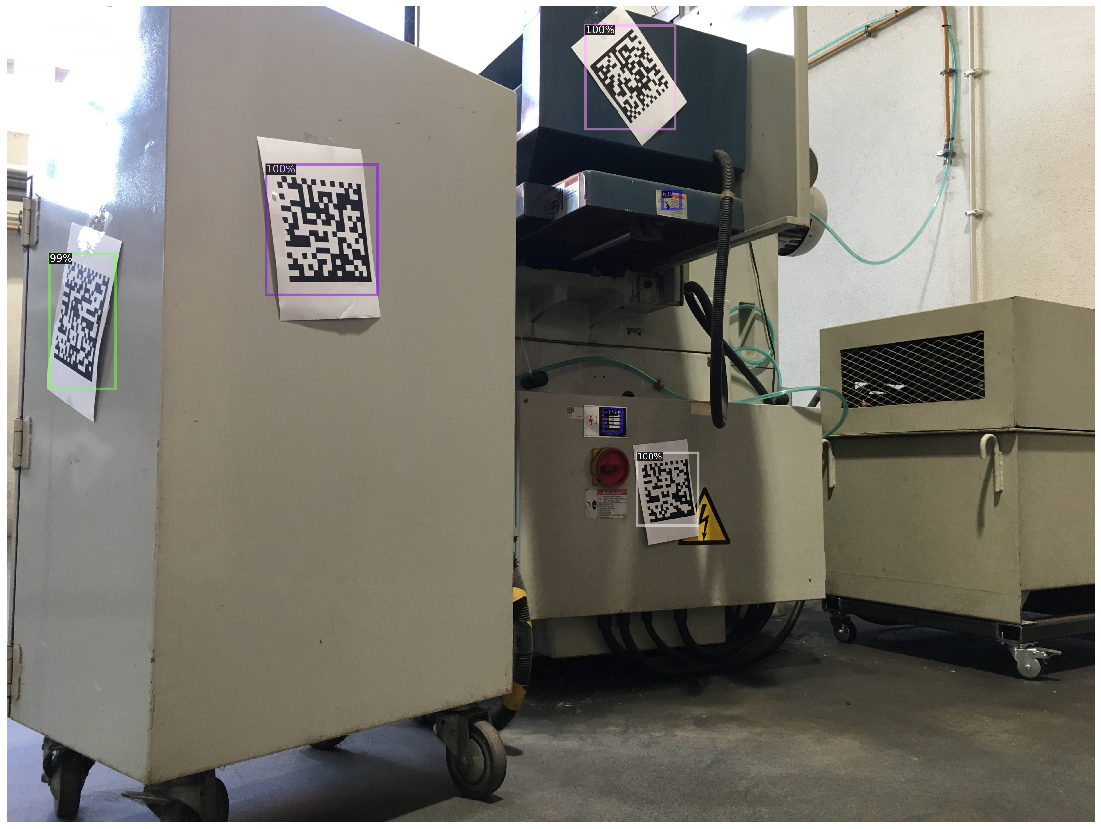

In [38]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
_, ax = plt.subplots(figsize=(20, 15))
ax.axis('off')
ax.imshow(v.get_image()[:, :, ::-1]);